In [1]:
import pysal as ps
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from math import ceil

from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler, MinMaxScaler

rbs = RobustScaler(quantile_range=[0.025,0.975])
mms = MinMaxScaler(feature_range=(0,1))
pts = PowerTransformer()
scaler = StandardScaler()

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from esda.adbscan import ADBSCAN
from sklearn.decomposition import PCA

pd.get_option("max_info_columns")

100

In [2]:
pd.set_option("display.max_info_columns", 300) 

gdf = gpd.read_file(f"zip://statistical-gis-boundaries-london.zip!statistical-gis-boundaries-london/ESRI/LSOA_2011_London_gen_MHW.shp")
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   LSOA11CD   4835 non-null   object  
 1   LSOA11NM   4835 non-null   object  
 2   MSOA11CD   4835 non-null   object  
 3   MSOA11NM   4835 non-null   object  
 4   LAD11CD    4835 non-null   object  
 5   LAD11NM    4835 non-null   object  
 6   RGN11CD    4835 non-null   object  
 7   RGN11NM    4835 non-null   object  
 8   USUALRES   4835 non-null   int64   
 9   HHOLDRES   4835 non-null   int64   
 10  COMESTRES  4835 non-null   int64   
 11  POPDEN     4835 non-null   float64 
 12  HHOLDS     4835 non-null   int64   
 13  AVHHOLDSZ  4835 non-null   float64 
 14  geometry   4835 non-null   geometry
dtypes: float64(2), geometry(1), int64(4), object(8)
memory usage: 566.7+ KB


In [3]:
df = pd.read_csv('https://data.london.gov.uk/download/lsoa-atlas/0193f884-2ccd-49c2-968e-28aa3b1c480d/lsoa-data.csv',
                 encoding= 'unicode_escape', na_values=[':'], low_memory=False)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4837 entries, 0 to 4836
Data columns (total 277 columns):
 #   Column                                                                                                            Non-Null Count  Dtype  
---  ------                                                                                                            --------------  -----  
 0   Lower Super Output Area                                                                                           4835 non-null   object 
 1   Names                                                                                                             4835 non-null   object 
 2   Mid-year Population Estimates;All Ages;2001                                                                       4835 non-null   float64
 3   Mid-year Population Estimates;All Ages;2002                                                                       4835 non-null   float64
 4   Mid-year Population Estimates

In [5]:
df = df[['Lower Super Output Area','Household Income, 2011/12;Median Annual Household Income estimate (£)','House Prices;Median Price (£);2014',
        'Economic Activity;Economically active: Total;2011','Economic Activity;Economically inactive: Total;2011','Economic Activity;Employment Rate;2011',
        'Economic Activity;Unemployment Rate;2011','Health;Fair health (%);2011','Public Transport Accessibility Levels (2014);Average Score;']]
df.head()

Lower Super Output Area  \
0               E01000907   
1               E01000908   
2               E01000909   
3               E01000912   
4               E01000913   

   Household Income, 2011/12;Median Annual Household Income estimate (£)  \
0                                            30223.0                       
1                                            32049.0                       
2                                            58469.0                       
3                                            31551.0                       
4                                            73024.0                       

  House Prices;Median Price (£);2014  \
0                             568500   
1                             350000   
2                            1412500   
3                             725000   
4                             996585   

   Economic Activity;Economically active: Total;2011  \
0                                              719.0   
1                                              833.0   
2                                              886.0   
3                                              848.0   
4                                              963.0   

   Economic Activity;Economically inactive: Total;2011  \
0                                              343.0     
1                                              351.0     
2                                              367.0     
3                                              387.0     
4                                              323.0     

   Economic Activity;Employment Rate;2011  \
0                                    58.6   
1                                    62.3   
2                                    65.7   
3                                    58.8   
4                                    71.8   

   Economic Activity;Unemployment Rate;2011  Health;Fair health (%);2011  \
0                                       9.9                         13.2   
1                                       8.0                         12.4   
2                                       4.9                         10.0   
3                                       8.8                         14.6   
4                                       2.1                          7.3   

   Public Transport Accessibility Levels (2014);Average Score;  
0                                                4.6            
1                                                2.9            
2                                                3.3            
3                                                4.6            
4                                                2.8

In [6]:
df.columns = ['lsoa','Income','House_Price','Eco_Active','Eco_inactive','Employment','Unemployment','Fair_Health','PTAL']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4837 entries, 0 to 4836
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lsoa          4835 non-null   object 
 1   Income        4835 non-null   float64
 2   House_Price   4835 non-null   object 
 3   Eco_Active    4835 non-null   float64
 4   Eco_inactive  4835 non-null   float64
 5   Employment    4835 non-null   float64
 6   Unemployment  4835 non-null   float64
 7   Fair_Health   4835 non-null   float64
 8   PTAL          4835 non-null   float64
dtypes: float64(7), object(2)
memory usage: 340.2+ KB


In [7]:
df['House_Price'] = pd.to_numeric(df['House_Price'],errors='coerce')

In [8]:
pd.isnull(df).sum() > 0

lsoa            True
Income          True
House_Price     True
Eco_Active      True
Eco_inactive    True
Employment      True
Unemployment    True
Fair_Health     True
PTAL            True
dtype: bool

In [10]:
print(df[df['House_Price'].isnull()])

           lsoa   Income  House_Price  Eco_Active  Eco_inactive  Employment  \
1347  E01003968  21873.0          NaN       691.0         336.0        49.8   
2872  E01001051  21910.0          NaN       631.0         365.0        52.9   
4835        NaN      NaN          NaN         NaN           NaN         NaN   
4836        NaN      NaN          NaN         NaN           NaN         NaN   

      Unemployment  Fair_Health  PTAL  
1347          15.1         13.1   3.0  
2872          11.6         15.5   2.7  
4835           NaN          NaN   NaN  
4836           NaN          NaN   NaN  


In [11]:
print(df[df['PTAL'].isnull()])

     lsoa  Income  House_Price  Eco_Active  Eco_inactive  Employment  \
4835  NaN     NaN          NaN         NaN           NaN         NaN   
4836  NaN     NaN          NaN         NaN           NaN         NaN   

      Unemployment  Fair_Health  PTAL  
4835           NaN          NaN   NaN  
4836           NaN          NaN   NaN  


In [12]:
print(df.shape)

df = df.dropna()

print(df.shape)

(4837, 9)
(4833, 9)


In [13]:
ppd = pd.merge(gdf, df, left_on='LSOA11CD', right_on='lsoa', how='inner').reset_index()
ppd.shape
ppd.sample(3)

index   LSOA11CD      LSOA11NM   MSOA11CD     MSOA11NM    LAD11CD  \
1418   1418  E01001440  Enfield 012A  E02000288  Enfield 012  E09000010   
210     210  E01000215   Barnet 037B  E02000060   Barnet 037  E09000003   
339     339  E01000344   Bexley 025B  E02000089   Bexley 025  E09000004   

      LAD11NM    RGN11CD RGN11NM  USUALRES  ...  \
1418  Enfield  E12000007  London      1641  ...   
210    Barnet  E12000007  London      2033  ...   
339    Bexley  E12000007  London      1609  ...   

                                               geometry       lsoa   Income  \
1418  POLYGON ((535117.777 197366.282, 535122.771 19...  E01001440  24534.0   
210   POLYGON ((524261.429 188571.767, 524311.472 18...  E01000215  39634.0   
339   POLYGON ((545202.826 173773.760, 545248.522 17...  E01000344  38035.0   

      House_Price  Eco_Active Eco_inactive Employment  Unemployment  \
1418     298500.0       748.0        404.0       54.0          11.0   
210      532500.0       866.0        385.0       62.9           4.4   
339      314000.0       834.0        298.0       68.6           3.4   

      Fair_Health  PTAL  
1418         13.6   3.2  
210           8.2   3.7  
339          12.3   2.3  

[3 rows x 25 columns]

In [14]:
def replace_legend_items(legend, mapping):
    for txt in legend.texts:
        for k,v in mapping.items():
            if txt.get_text() == str(k):
                txt.set_text(v)

In [15]:
tfont = {'fontname':'Liberation Sans Narrow', 'horizontalalignment':'left'}

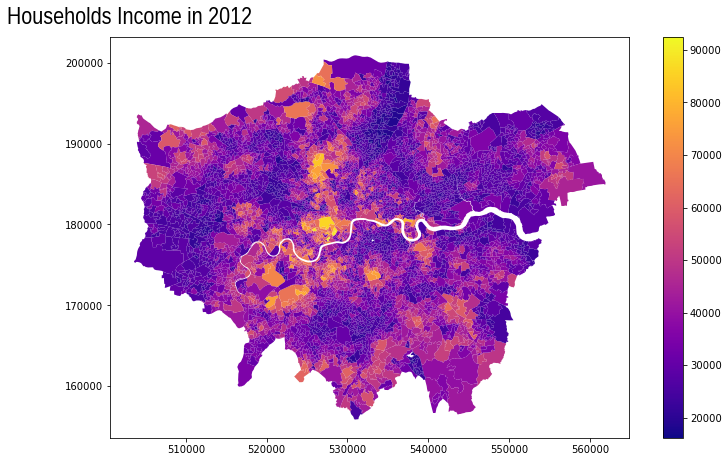

In [16]:
f = plt.figure()
f.set_size_inches(12,7)

ax1 = f.add_subplot()
ppd.plot(column='Income', legend=True, cmap='plasma', figsize=(12,6), ax=ax1)

f.subplots_adjust(top=0.92)
f.suptitle(f"Households Income in 2012", x=0.025, size=24, **tfont);

In [17]:
ppd = ppd[['LSOA11NM','LSOA11CD','geometry','Income','House_Price','Eco_Active','Eco_inactive','Employment','Unemployment','Fair_Health','PTAL']].copy()
ppd.head()

LSOA11NM   LSOA11CD  \
0        City of London 001A  E01000001   
1        City of London 001B  E01000002   
2        City of London 001C  E01000003   
3        City of London 001E  E01000005   
4  Barking and Dagenham 016A  E01000006   

                                            geometry   Income  House_Price  \
0  POLYGON ((532105.092 182011.230, 532162.491 18...  58347.0     720000.0   
1  POLYGON ((532746.813 181786.891, 532671.688 18...  57159.0     836500.0   
2  POLYGON ((532135.145 182198.119, 532158.250 18...  34387.0     487500.0   
3  POLYGON ((533807.946 180767.770, 533649.063 18...  24000.0     414500.0   
4  POLYGON ((545122.049 184314.931, 545271.917 18...  39141.0     267500.0   

   Eco_Active  Eco_inactive  Employment  Unemployment  Fair_Health  PTAL  
0       964.0         257.0        74.9           3.5          9.4   8.0  
1       926.0         270.0        74.8           1.7          7.4   8.0  
2       822.0         280.0        67.2           4.7         13.2   7.3  
3       530.0         243.0        58.9           8.7         13.3   8.0  
4       874.0         377.0        58.6           9.5          9.7   6.4

In [18]:
to_cluster = ppd[['LSOA11CD','Income','House_Price','Eco_Active','Eco_inactive','Employment','Unemployment','Fair_Health','PTAL']].set_index('LSOA11CD').copy()
to_cluster.head()

Income  House_Price  Eco_Active  Eco_inactive  Employment  \
LSOA11CD                                                                
E01000001  58347.0     720000.0       964.0         257.0        74.9   
E01000002  57159.0     836500.0       926.0         270.0        74.8   
E01000003  34387.0     487500.0       822.0         280.0        67.2   
E01000005  24000.0     414500.0       530.0         243.0        58.9   
E01000006  39141.0     267500.0       874.0         377.0        58.6   

           Unemployment  Fair_Health  PTAL  
LSOA11CD                                    
E01000001           3.5          9.4   8.0  
E01000002           1.7          7.4   8.0  
E01000003           4.7         13.2   7.3  
E01000005           8.7         13.3   8.0  
E01000006           9.5          9.7   6.4

In [31]:
to_cluster['Income'] = to_cluster['Income']/1000
to_cluster['House_Price'] = to_cluster['House_Price']/1000

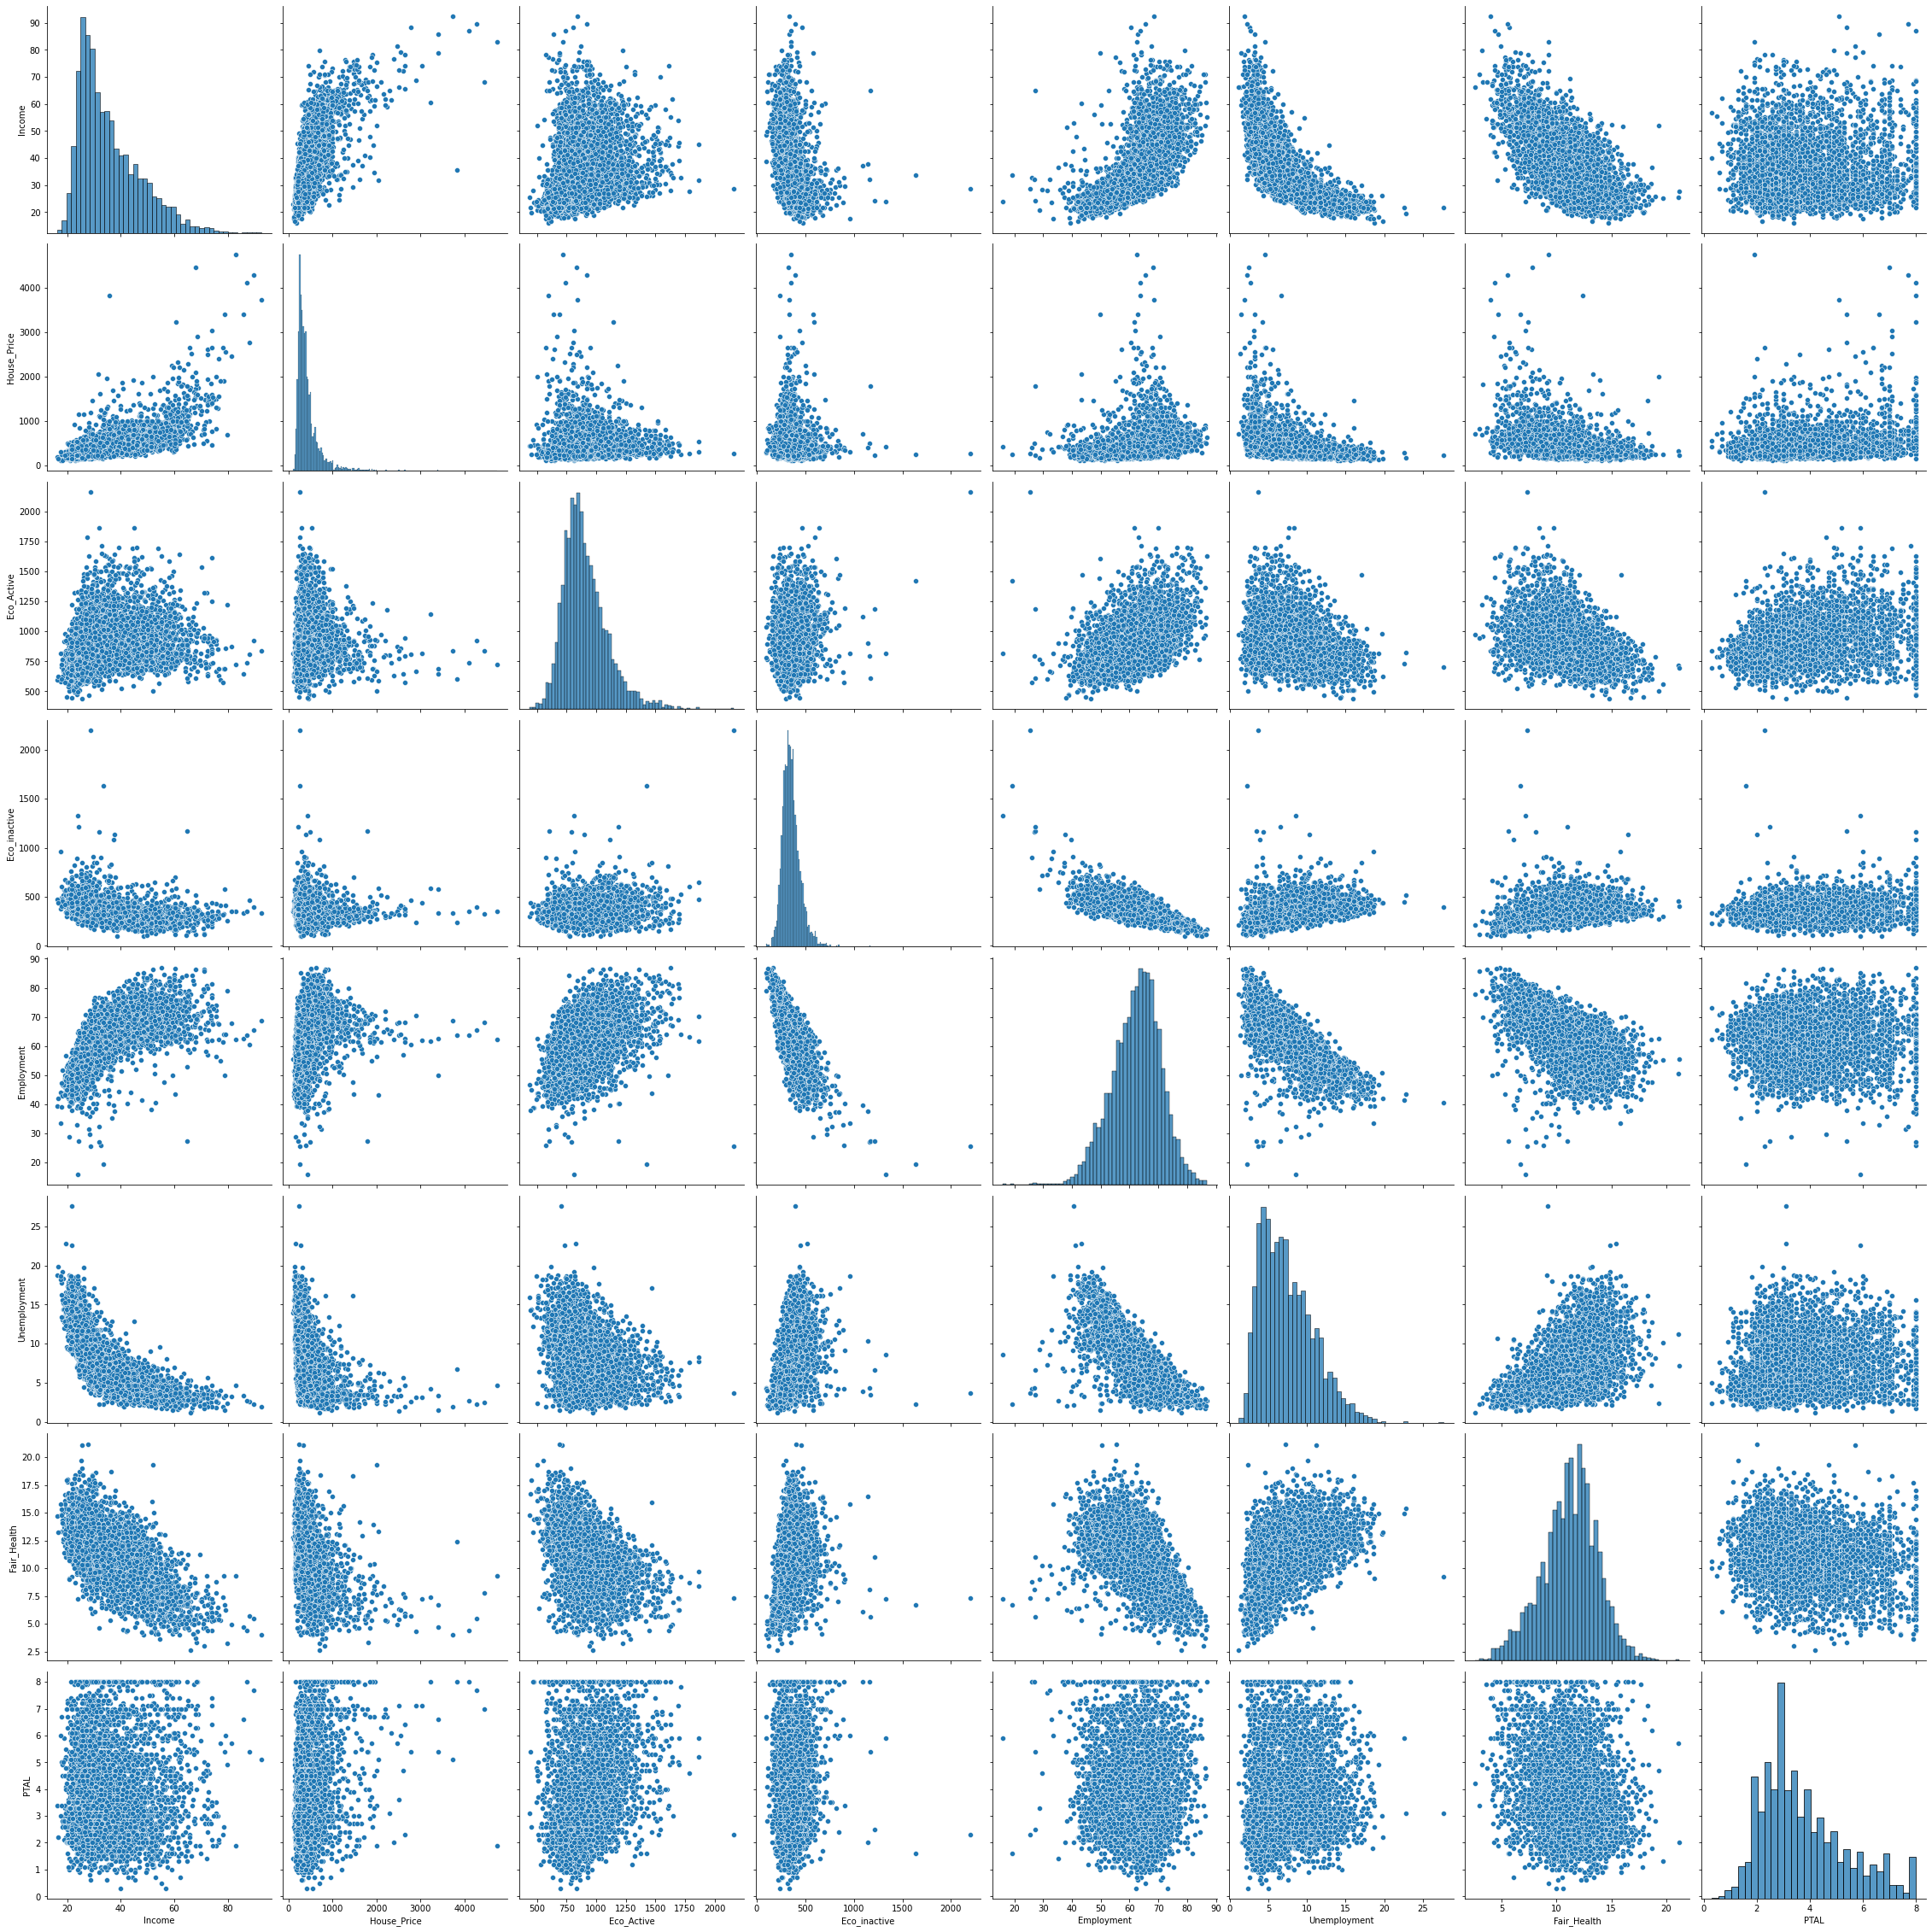

In [32]:
plot_norm = sns.pairplot(to_cluster,height = 4)

In [33]:
normed = to_cluster.copy()
for c in to_cluster.columns.values:
    normed[c] = pts.fit_transform(to_cluster[c].values.reshape(-1,1))
normed.sample(5)

Income  House_Price  Eco_Active  Eco_inactive  Employment  \
LSOA11CD                                                                 
E01002745  1.308854     1.184585    0.336182     -1.023341    1.106075   
E01003271  1.159331    -0.195022    0.346800     -0.264709    0.895099   
E01000322 -0.207605    -0.307820    0.430548      0.184258    0.272471   
E01000527 -1.543125    -0.209579    0.674488      1.298417   -0.972589   
E01004474  0.782217     0.388502    2.344346     -2.505635    2.612518   

           Unemployment  Fair_Health      PTAL  
LSOA11CD                                        
E01002745     -0.490163    -0.431902  0.153512  
E01003271     -1.232730     0.818213 -1.236381  
E01000322     -0.452439     0.080446 -0.935928  
E01000527      1.277582     0.445371 -0.751905  
E01004474     -0.728713    -1.679243  1.609585

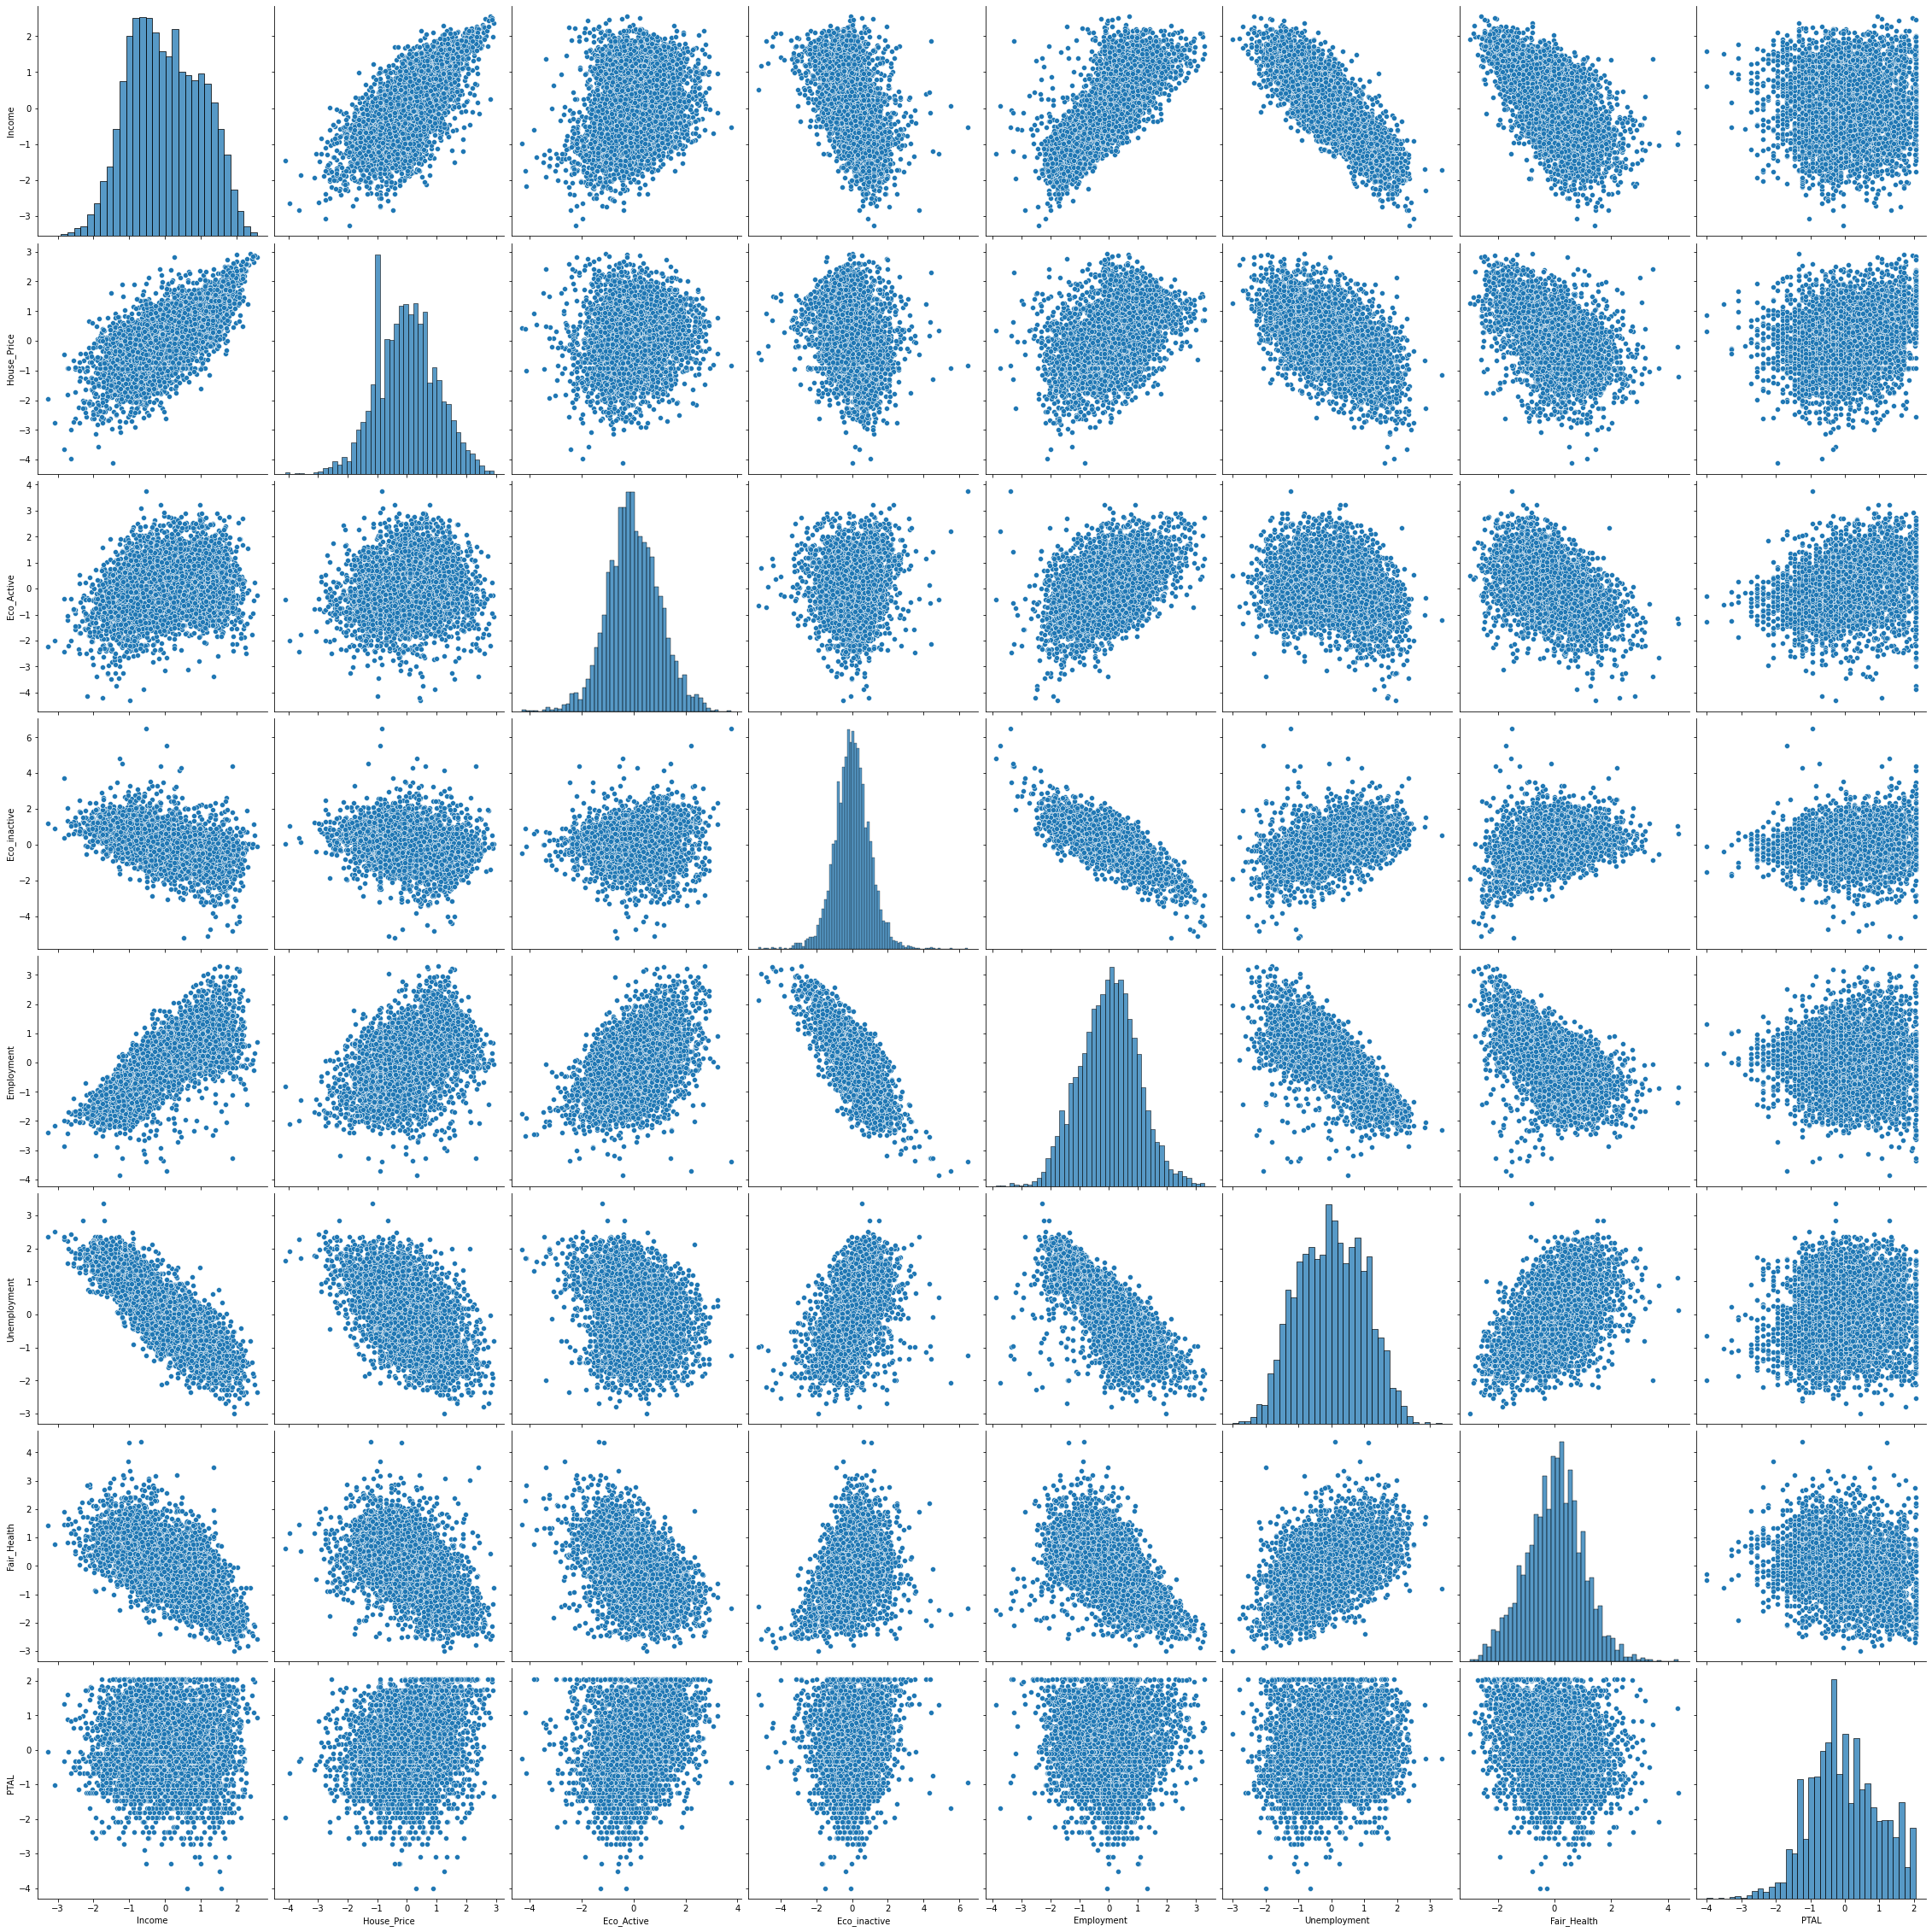

In [34]:
plot_norm = sns.pairplot(normed,height = 4)

In [35]:
rand_st_int = 10 
pca = PCA(random_state=rand_st_int)

normed_pca = pca.fit_transform(normed)
print('Explained variance ratio of each component:')
print(pca.explained_variance_ratio_)

Explained variance ratio of each component:
[0.50609682 0.18652108 0.11294572 0.09137872 0.05327212 0.03207646
 0.01509895 0.00261014]


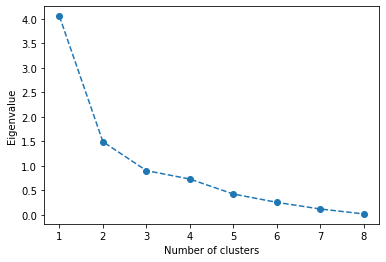

In [36]:
dfpc = pd.DataFrame({'eigenvalue':pca.explained_variance_,
             'PC':list(range(1, pca.n_components_ + 1))})

plt.plot(dfpc['PC'], dfpc['eigenvalue'], marker='o', linestyle = '--')
plt.xlabel('Number of clusters')
plt.ylabel('Eigenvalue')
plt.show()

In [37]:
pca = PCA(n_components = 2)

normed_pca = pca.fit_transform(normed)
print('Explained variance ratio of each component:')
print(pca.explained_variance_ratio_)

Explained variance ratio of each component:
[0.50609682 0.18652108]


In [38]:
list_var = normed.columns.tolist()
print(list_var)

['Income', 'House_Price', 'Eco_Active', 'Eco_inactive', 'Employment', 'Unemployment', 'Fair_Health', 'PTAL']


In [39]:
df_PrincipleComp = pd.DataFrame(pca.components_, columns = list_var)
df_PrincipleComp

Income  House_Price  Eco_Active  Eco_inactive  Employment  Unemployment  \
0  0.453704     0.342608    0.207871     -0.324848    0.447909     -0.427180   
1 -0.065950     0.178009    0.513750      0.398554   -0.117831      0.185382   

   Fair_Health      PTAL  
0    -0.377375  0.050180  
1    -0.239722  0.659895

In [40]:
score_pca = pca.transform(normed)
score_pca

array([[ 3.2981353 ,  1.00121408],
       [ 4.02188445,  0.97279535],
       [ 0.83014218,  0.40751498],
       ...,
       [-1.62633238,  0.10167487],
       [-0.2842093 , -0.59513158],
       [ 1.7087131 ,  0.10029986]])

In [41]:
print('Eigenvalues of each component:')
print(pca.explained_variance_)

Eigenvalues of each component:
[4.04961244 1.49247742]


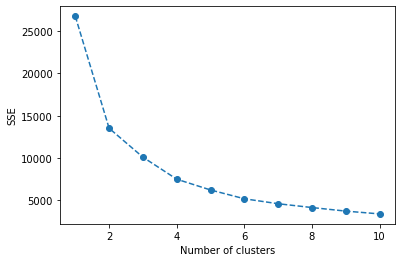

In [42]:
# calculate SSE for a range of number of cluster
list_SSE = []
min_k = 1
max_k = 10
range_k = range(min_k, max_k+1)
for i in range_k:
    km = KMeans(
        n_clusters=i, init='k-means++', random_state=0)
    km.fit(score_pca)
    # inertia is a concept in physics. Roughly it means SSE of clustering.
    list_SSE.append(km.inertia_)

# plot
plt.plot(range_k, list_SSE, marker='o', linestyle = '--')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [43]:
k_cluster = 2
random_seed = 1
kmeans_method = KMeans(n_clusters=k_cluster,random_state=random_seed)
kmeans_method.fit(score_pca)

KMeans(n_clusters=2, random_state=1)

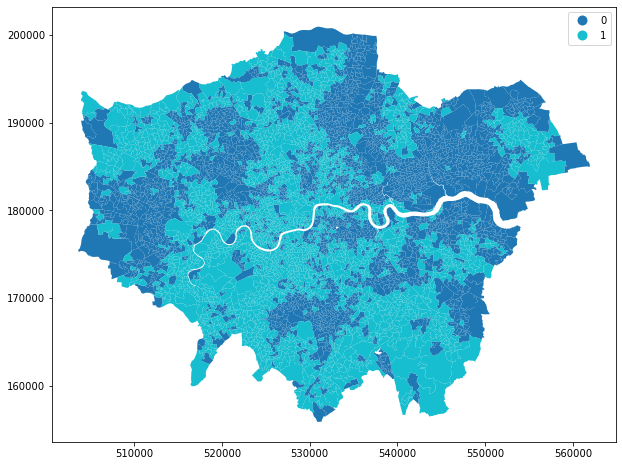

In [44]:
ppd['Kmeans_Cluster'] = kmeans_method.labels_
ppd.plot(column='Kmeans_Cluster', categorical=True, legend=True, figsize=(12,8));

In [45]:
ppd_kpca = pd.concat([ppd.reset_index(drop = True), pd.DataFrame(score_pca)],axis = 1)
ppd_kpca.columns.values[-2: ] = ['Component1','Component2']

In [46]:
ppd_kpca['Segement'] = ppd_kpca['Kmeans_Cluster'].map({0:'First',1:'Second',2:'Third',3:'Forth'})

In [47]:
ppd_kpca.head()

LSOA11NM   LSOA11CD  \
0        City of London 001A  E01000001   
1        City of London 001B  E01000002   
2        City of London 001C  E01000003   
3        City of London 001E  E01000005   
4  Barking and Dagenham 016A  E01000006   

                                            geometry   Income  House_Price  \
0  POLYGON ((532105.092 182011.230, 532162.491 18...  58347.0     720000.0   
1  POLYGON ((532746.813 181786.891, 532671.688 18...  57159.0     836500.0   
2  POLYGON ((532135.145 182198.119, 532158.250 18...  34387.0     487500.0   
3  POLYGON ((533807.946 180767.770, 533649.063 18...  24000.0     414500.0   
4  POLYGON ((545122.049 184314.931, 545271.917 18...  39141.0     267500.0   

   Eco_Active  Eco_inactive  Employment  Unemployment  Fair_Health  PTAL  \
0       964.0         257.0        74.9           3.5          9.4   8.0   
1       926.0         270.0        74.8           1.7          7.4   8.0   
2       822.0         280.0        67.2           4.7         13.2   7.3   
3       530.0         243.0        58.9           8.7         13.3   8.0   
4       874.0         377.0        58.6           9.5          9.7   6.4   

   Kmeans_Cluster  Component1  Component2 Segement  
0               1    3.298135    1.001214   Second  
1               1    4.021884    0.972795   Second  
2               1    0.830142    0.407515   Second  
3               0   -1.291377   -0.627997    First  
4               0   -0.344156    1.278865    First

/opt/conda/envs/sds2020/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


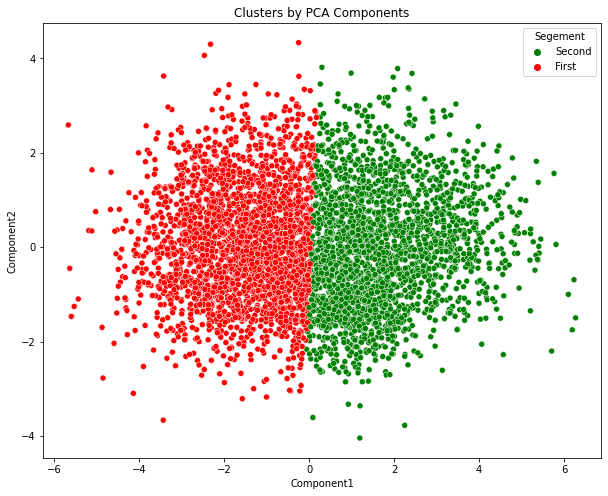

In [48]:
x_axis = ppd_kpca['Component1']
y_axis = ppd_kpca['Component2']
plt.figure(figsize = (10, 8))
sns.scatterplot(x_axis,y_axis,hue = ppd_kpca['Segement'], palette = ['g','r'])
plt.title('Clusters by PCA Components')
plt.show()